In [1]:
import sys 
sys.path.append("../src/")

import math
from tqdm import tqdm

from GraphBuilder import GraphBuilder
from GraphState import GraphState, GraphEvaluator
from GeneticEvaluatorOptim import GeneticEvaluator
from HybridEvaluator import HybridEvaluator
from MCSTree import MCST,State, MonteCarloTreeNode, Policies
from MCSTreeUtils import MCSTreeGraph
from GrammarLoader import GrammarLoader
from GraphUtils import *

C:\Users\smora\AppData\Roaming\Python\Python310\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:
# import math
import math
from typing import Tuple, Dict, List
import json
import networkx as nx
import numpy as np
from GraphState import GraphEvaluator, GraphState
from GeneticAlgorithm import GeneticAlgorithm, Individual, ExponentialRankSelector, PartiallyMappedCrossover, ReverseSequenceMutation, SinglePointCrossover, SimpleBoundedMutation


from typing import Dict, List
import json
import math

class MappingEvaluator():
    
    def __init__(self, data_flows, graph=None):
        self.data_flows=data_flows        
        self.graph=graph
        
        if graph is not None:
             self.module_list = list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'M'])
            
        self.shortest_paths = {}
        self.simple_paths = {}
        self.switch_paths = {}
        
    def calculate_SW_connectivity(self,graph,cutoff=3):
        
        switch_connectivity=0
        switch_list=list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'S'])
        
        count=0
        
        for s in switch_list:
            leaves = [d for d in switch_list if d!=s and (s,d) not in self.switch_paths]
            count+=len(leaves )
            if len(leaves)>0:
                paths = nx.all_simple_paths(graph, s, leaves, cutoff=6)
                for path in paths:
                    path=list(path)
                    if (s, path[-1]) in self.switch_paths:
                        self.switch_paths[(s,path[-1])]+=1
                        n_paths=self.switch_paths[(s,path[-1])]
                        if n_paths==2:
                            switch_connectivity+=1
                    else: 
                        self.switch_paths[(s,path[-1])]=1    
                                              
        return len([n for n in self.switch_paths.values() if n>1])/max(1,len(list(self.switch_paths.values())))
                   
    def count_hops(self,graph,module_list):
        
        hops=np.zeros(len(self.data_flows))
        for index, c in enumerate(self.data_flows):
            if (module_list[c[0]], module_list[c[1]]) not in self.shortest_paths:
                try:
                    shortest_path = list(nx.shortest_path(graph, source=module_list[c[0]], target=module_list[c[1]]))
                except nx.NetworkXNoPath:
                    return None
                
                self.shortest_paths[(module_list[c[0]], module_list[c[1]])]=shortest_path
            else:
                shortest_path=self.shortest_paths[(module_list[c[0]], module_list[c[1]])]
            hops[index] = len(shortest_path)-1
                
        return hops
    
    def calculate_link_loads(self,graph,module_list,edge_list):
        
        edge_loads = np.zeros(len(edge_list))
    
        for index, c in enumerate(self.data_flows):
            if (module_list[c[0]], module_list[c[1]]) not in self.shortest_paths:
                try:
                    shortest_path = list(nx.shortest_path(graph, source=module_list[c[0]], target=module_list[c[1]])) 
                except nx.NetworkXNoPath:
                    return None
                    
                self.shortest_paths[(module_list[c[0]], module_list[c[1]])]=shortest_path
            else:
                shortest_path=self.shortest_paths[(module_list[c[0]], module_list[c[1]])]
            for h in range(0, len(shortest_path) - 1):
                edge_loads[edge_list.index((shortest_path[h], shortest_path[h + 1]))] += c[2]
        
        return edge_loads
        
    def count_link_overloads(self,loads,target):
        return (loads / 100e6 > target).sum()
    
    def max_link_load(self,loads):
        return np.max(loads / 100e6)
    
        
    def calculate_LC_scores(self, graph, module_list, alpha=1):
        max_load_target=0.79999999999
        
        edge_list = list(graph.edges())
        
        
        loads = self.calculate_link_loads(graph,module_list,edge_list)
        hops = self.count_hops(graph,module_list)
        
        if loads is not None and hops is not None: 
            max_load = self.max_link_load(loads)
            overload_count = self.count_link_overloads(loads,max_load_target)
            mean_hops = np.mean(hops)
            max_hops = np.max(hops).astype(int)
            latency_score = 2*math.exp(1-max_load/max_load_target   - overload_count)/mean_hops
            
            for i,e in enumerate(edge_list):
                graph.edges[e]["utilization"] = loads[i] / 100e6
        else:
            overload_count="N.A"
            max_hops=float("inf")
            mean_hops=float("inf")
            max_load="N.A"
            latency_score=1e-9
        
        SW_connectivity = self.calculate_SW_connectivity(graph,cutoff=max_hops+2)

        connectivity_score = alpha*SW_connectivity
        
        return latency_score, connectivity_score, \
                                {'max_load': max_load, 'overload_count':overload_count, 'mean_hops': mean_hops,\
                               'max_hops': max_hops, 'latency_score':latency_score,'connectivity_score':connectivity_score,\
                               'SW_connectivity':SW_connectivity}
    
    def evaluate(self, individual : Individual):
        
        if isinstance(individual,Individual): 
            ordering_list = individual.genome 
            if self.graph is not None:
                module_order=[self.module_list[n] for n in ordering_list] 
                latency, connectivity, stats=self.calculate_LC_scores(self.graph,module_order,alpha=1)
                beta=0.25
                return (latency*(1-beta)+connectivity*(beta))
            else:
                raise Exception("Evaluate can only be used if graph is set")
        else:
                raise TypeError("Evaluate argument has to be a genetic algorithm individual")
                

class RoutingEvaluator():
    
    def __init__(self, data_flows, path_dict,graph=None):
        self.data_flows=data_flows        
        self.graph=graph
        self.path_dict = path_dict
                           
    def count_hops(self,path_list):
        
        paths=[self.path_dict[(self.data_flows[i][0],self.data_flows[i][1])][1][p] for i,p in enumerate(path_list)]
        hops=[self.path_dict[(self.data_flows[i][0],self.data_flows[i][1])][2][p] for i,p in enumerate(path_list)] 
        return hops
    
    def calculate_link_loads(self,graph,path_list,edge_list):
        
        edge_loads = np.zeros(len(edge_list))
        paths=[self.path_dict[(self.data_flows[i][0],self.data_flows[i][1])][1][p] for i,p in enumerate(path_list)]
        bw=[self.data_flows[i][2] for i,_ in enumerate(path_list)]
        
     
        for i,p in enumerate(paths):
            if isinstance(p, list):
                #print(p)
                for h in range(0, len(p) - 1):
                   
                    #print((p[h], p[h + 1]))
                    edge_loads[edge_list.index((p[h], p[h + 1]))] += bw[i]
            
        return edge_loads
        
    def count_link_overloads(self,loads,target):
        return (loads / 100e6 > target).sum()
    
    def max_link_load(self,loads):
        return np.max(loads / 100e6)
    
        
    def calculate_latency_scores(self, graph, path_list, alpha=1):
        max_load_target=0.79999999999
        
        edge_list = list(graph.edges())
        
        
        loads = self.calculate_link_loads(graph,path_list,edge_list)
        hops = self.count_hops(path_list)
        #print(hops)
        
        if loads is not None and hops is not None: 
           
            max_load = max(max_load_target,self.max_link_load(loads))
            overload_count = self.count_link_overloads(loads,max_load_target)
            #print(overload_count)
            #print(loads/100e6)
            mean_hops = np.mean(hops)
            max_hops = np.max(hops).astype(int)
           
            
            for i,e in enumerate(edge_list):
                if loads[i]>0.0:
                    graph.edges[e]["utilization"] = loads[i] / 100e6
                
            #graph_edge_utilization=[y["utilization"] for x,y in graph.edges() if y and ["utilization"] in y]
            #max_load=np.max(np.asarray(graph_edge_utilization))
            
            latency_score = 2*math.exp(1-max_load/max_load_target   - overload_count)/mean_hops
        
        else:
            print("FELLLL HERE")
            overload_count="N.A"
            max_hops=float("inf")
            mean_hops=float("inf")
            max_load="N.A"
            latency_score=1e-9
        
        return latency_score, {'max_load': max_load, 'overload_count':overload_count, 'mean_hops': mean_hops, 'max_hops': max_hops, 'latency_score':latency_score,}
    
    def evaluate(self, individual : Individual):
        if isinstance(individual,Individual): 
            path_list = individual.genome 
            if self.graph is not None:
                latency, stats=self.calculate_latency_scores(self.graph,path_list,alpha=1)
                return latency
            else:
                raise Exception("Evaluate can only be used if graph is set")
        else:
                raise TypeError("Evaluate argument has to be a genetic algorithm individual")
   

class GeneticRouter(GraphEvaluator):
    module_threshold : int
    generations : int
    weights : Dict[str,float]
    data_flows : List[tuple[int,int,float]]
    


    def __init__(self, weights : Dict[str,float], module_threshold: int =0, pop_size : int =50, generations : int = 3, filename : str ="data/connections.json",seed=12345):
        self.pop_size = pop_size 
        self.generations = generations 
        self.module_threshold=module_threshold
        self.weights = weights
        self.rng = np.random.default_rng(seed)
      
        

        with open(filename) as file:
            self.data_flows = json.loads(json.load(file))
        
        self.data_flows=[f for f in self.data_flows if f[0] <19]
        self.module_threshold=max([max(f[0],f[1]) for f in self.data_flows])+1
    
    def update_seed(self,seed):
        self.rng = np.random.default_rng(seed)

    def __str__(self) -> str:
        ret_str = f"module_threshold: {self.module_threshold}\n"
        ret_str += f"pop_size: {self.pop_size} \n"
        ret_str += f"generations {self.generations} \n"
        ret_str += str(self.weights)

        return ret_str


    def trim_graph(self, graph):
        graph
        nodes_to_remove=[]
        changed=True
        while(changed):
            changed=False
            for x,y in graph.nodes(data=True):
                if graph.degree(x) >2 and y['idType']=='M':
                    edges_to_remove=[(x,z) for z  in graph.neighbors(x)][0:-1]+[(z,x) for z in graph.neighbors(x)][0:-1]
                    graph.remove_edges_from(edges_to_remove)
                    changed=True
                if graph.degree(x) <=2 and y['idType']=='S':
                    switches=[n for n in graph.neighbors(x) if graph.nodes[n]["idType"]=='S']
                    if len(switches)==1:
                        nodes_to_remove.append(x)
                        changed=True
                elif graph.degree(x) == 4 and y['idType']=='S':
                    switches=[n for n in graph.neighbors(x) if graph.nodes[n]["idType"]=='S']
                    modules=[n for n in graph.neighbors(x) if graph.nodes[n]["idType"]=='M']
                    if len(switches)==1 and len(modules)==1:
                        nodes_to_remove.append(x)
                        graph.add_edge(switches[0],modules[0])
                        graph.add_edge(modules[0],switches[0])
                        changed=True
            graph.remove_nodes_from(nodes_to_remove)     
    
   

    def evaluate_LC(self, graph,alpha=1):

        module_list = list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'M'])
        all_connected = sum([1 for x in module_list if graph.degree(x) ==2 ])
            
        genome_size = len(module_list)
        
        mapping_evaluator=MappingEvaluator(self.data_flows,graph=graph)
        
        
        if all_connected<self.module_threshold:
            SW_connectivity=mapping_evaluator.calculate_SW_connectivity(graph,6)
            connectivity_score=SW_connectivity*(alpha)
            #connectivity_score=0
            return 0, connectivity_score, \
                    {'connectivity_score': connectivity_score,'SW_connectivity':SW_connectivity,'latency_score':0}, \
                    module_list
        
   
        seed_sel=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        seed_cross=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        seed_mut=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        
        selector=ExponentialRankSelector(seed=seed_sel)
        crossop=PartiallyMappedCrossover(seed=seed_cross)
        mutop=ReverseSequenceMutation(seed=seed_mut)
        
              
        class MappingGenomeInitializer:
            def __init__(self, seed=None):
                self.rng=np.random.default_rng(seed)
            def __call__(self,genome):
                linspace=np.linspace(start=0,stop=len(genome)-1, num=len(genome),dtype=int)
                self.rng.shuffle(linspace)
                return linspace
        
        seed_init=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
        init_fn=MappingGenomeInitializer(seed_init)
        
        ga = GeneticAlgorithm(genome_size = genome_size, crossover_operator=crossop, 
                          mutation_operator=mutop, evaluator=mapping_evaluator, selector=selector)

        individuals, fitness= ga.run(pop_size = self.pop_size, generations=self.generations, init_fn=init_fn)
        
    
        module_list=[module_list[n] for n in individuals[0].genome]
        latency_score,connectivity_score,stats=mapping_evaluator.calculate_LC_scores(graph,module_list,alpha=alpha )
        
        
        #print("current best \n ",stats)
        
        ##---------------------------------------------------------------------------------------------p----------------------------
        ##Routing Stage starts Here    
        if latency_score > 1e-3:
            switch_list=list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] == 'S'])
            #print(switch_list)


            edge_list=[edge for edge in enumerate(graph.edges()) if edge[0] in switch_list and edge[1] in switch_list]

            switch_exchanges=[]
            for i, c in enumerate(self.data_flows):
                source=[x for x in graph.neighbors(module_list[c[0]])][0]
                destination=[x for x in graph.neighbors(module_list[c[1]])][0]
                switch_exchanges.append((source,destination,c[2]))


            exchange_paths={}
            for exchange in switch_exchanges:
                if not exchange[0]==exchange[1]:
                    #path_list=list(nx.all_simple_paths(graph,exchange[0],exchange[1],cutoff=stats["max_hops"]-2))
                    #print(path_list)
                    path_list=list(nx.all_shortest_paths(graph,exchange[0],exchange[1]))
                    #print(path_list)
                    #print([len(x)+1 for x in path_list])
                    if (exchange[0],exchange[1]) not in exchange_paths:
                        exchange_paths[(exchange[0],exchange[1])]=(len(path_list),path_list,[len(x)+1 for x in path_list]) #(number of paths, list of paths, length of paths)   
                elif  exchange[0]==exchange[1]:
                        exchange_paths[(exchange[0],exchange[1])]=(1,[exchange[0],exchange[1]],[2]) #(number of paths, list of paths, length of paths)
            
            stats.update({'shortest_routing_options':np.prod(np.asarray([x[0] for x in exchange_paths.values() if x[0]>1]))} )
            #print([x[0] for x in exchange_paths.values() if x[0]>1],np.prod(np.asarray([x[0] for x in exchange_paths.values() if x[0]>1])))
            routing_evaluator=RoutingEvaluator(switch_exchanges,exchange_paths,graph=graph)

            class RoutingGenomeInitializer:
                def __init__(self, path_numbers, seed=None):
                    self.rng=np.random.default_rng(seed)
                    self.path_numbers=path_numbers
                def __call__(self,genome):
                    if len(genome)==len(self.path_numbers):
                        return [np.random.randint(low=0,high=x) for x in self.path_numbers]
                    else:
                        raise Exception("Genome size and path_numbers list does not match")
            
            class IndexedBoundedMutation:
    
                def __init__(self,max_vector,seed=None):
                    self.rng=np.random.default_rng(seed)
                    self.max_vector=np.asarray(max_vector)

                def mutate(self,individual,rate=0.1):

                    if self.rng.random()<rate:

                        mutable_indexes=np.where(self.max_vector>1)[0]
                        if len(mutable_indexes)>3:
                            mutation_indexes = np.random.choice(mutable_indexes,np.random.randint(low=1,high=min(len(mutable_indexes),3)),replace=False)
                            individual.genome[mutation_indexes]=[np.random.randint(low=0,high=x) for x in self.max_vector[mutation_indexes]]
                        elif len(mutable_indexes)>0:
                            individual.genome[mutable_indexes]=[np.random.randint(low=0,high=x) for x in self.max_vector[mutable_indexes]]

                    return individual

            selector=ExponentialRankSelector(seed=seed_sel)
            crossop=SinglePointCrossover(seed=seed_cross)
            mutop=IndexedBoundedMutation(max_vector=[exchange_paths[(s,d)][0] for s,d,_ in switch_exchanges ],seed=seed_mut)
            #mutop=SimpleBoundedMutation(max_vector=[exchange_paths[(s,d)][0] for s,d,_ in switch_exchanges ],seed=seed_mut)

            seed_init=self.rng.integers(low=1,high=np.iinfo(np.int32).max)
            init_fn=RoutingGenomeInitializer([exchange_paths[(s,d)][0] for s,d,_ in switch_exchanges ],seed=seed_init)

            ga = GeneticAlgorithm(genome_size = len(switch_exchanges), crossover_operator=crossop, 
                              mutation_operator=mutop, evaluator=routing_evaluator, selector=selector)

            individuals, fitness= ga.run(pop_size = self.pop_size, generations=self.generations, init_fn=init_fn)
            path_list=individuals[0].genome

            latency_score,new_stats=routing_evaluator.calculate_latency_scores(graph,path_list)
            stats.update(new_stats)
        ##----------------------------------------------------------------------------------------------------------------------------------
        ##Routing Stage  ends Here
        
        
        return latency_score, connectivity_score, stats, module_list
    
    def evaluate_cost(self,graph):
        module_cost : float =10
        link_cost : float =0.1
        
        hardware_node_list = list([x for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] in ['S','M']])
       
        total_cost  = len(hardware_node_list) * 10 #+ graph.number_of_edges() * .1)
        normalized_cost = (self.module_threshold+1)*module_cost/ max(1,total_cost)
        
        if normalized_cost > 1:
            return 1/normalized_cost, {'total_cost':total_cost,'cost_score':1/normalized_cost}
        else:
            return normalized_cost, {'total_cost':total_cost,'cost_score':normalized_cost}
    
    
    def evaluate(self,state):
  
        self.trim_graph(state.graph)
        graph=state.graph
        
        stats={}
        latency_score, connectivity_score, LC_stats,_ = self.evaluate_LC(graph,alpha=1)
        
        cost_score, cost_stats = self.evaluate_cost(graph)
        
        stats.update(LC_stats),stats.update(cost_stats)
        
        score=1e-6
        score += latency_score*self.weights['latency'] + connectivity_score*self.weights['connectivity'] \
                + cost_score*self.weights['cost']
        score = score / (self.weights['latency']+self.weights['connectivity']+self.weights['cost'])
        score = max(5e-3,score)
          
        stats.update({'score':score})
        
        hardware_nodes = list([y['idType'] for x, y in graph.nodes(data=True) if 'idType' in y if y['idType'] in ['S','M']])
        stats.update({'num_modules':len([x for x in hardware_nodes if x=='M']),'num_switches':len([x for x in hardware_nodes if x=='S']), 'num_links': state.graph.number_of_edges()})
        
        return score, stats
        
    def is_terminal(self, state) -> bool:
        #return False
        #number_of_modules = sum([1 for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'M']) >= self.module_threshold
        #cost = state.graph.number_of_nodes() > 28
        
        all_modules=list([x for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'M'])
        all_connected = sum([1 for x in all_modules if state.graph.degree(x) ==2 ]) == self.module_threshold
        
        max_switches=len(list([x for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'S'])) > 12
        
        has_G=len(list([x for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'G']))>0
        
        #number_of_modules = sum([1 for x, y in state.graph.nodes(data=True) if y and 'idType' in y if y['idType'] == 'M']) > self.module_threshold
        return (all_connected and has_G) or max_switches 

In [12]:
import matplotlib as plt
import time
import os

def run_search(node,mct):
    root=node
    path=[]
    total_it=0
    for i in (pbar := tqdm(range(0,mct.max_depth))):
        selected_action, node, it = mct.search(node) 
        total_it+=it
        #print(selected_action[0])
        pbar.set_postfix({'iterations': it, 'nodes': len(mct.node_dict)})
        path.append(node)
        #node.state.draw({'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'G':['#7B934C', 'd']},size=(8,8),arc_rad=.125, edge_attribute="utilization")
        if node.state.is_terminal():
            if node.state.graph_evaluator.is_terminal(node.state):
                print("Exploration terminated: node is terminal by condition")
            else:
                print("Exploration terminated: node is terminal by rule starvation")
            return node, path, total_it
 
        
    return node, path

def netgap_search(grammar_filename, print_graph=True, save_filename=None, save_attribute = "score", save_th=0.2, search_loops=1,):
    
    #starts the seeds
    seed=2345423
    rng=np.random.default_rng(seed)  
    seed=rng.integers(low=1,high=np.iinfo(np.int32).max)
    
    
    #starts the grammar and the graph factory
    grammar_loader = GrammarLoader(grammar_filename)
    grammar = grammar_loader.load()

    graph_builder = GraphBuilder(grammar)
    
    #starts the evaluators
    weights={'latency': 12, 'connectivity': 6, 'cost' : 12}
    search_evaluator= GeneticRouter(weights=weights, pop_size=50, generations=3,seed=seed,\
                                            filename = "C:/Users/smora/Documents/LiU/Workspace//NetGAP/data/connections_extended.json")
    refinement_evaluator=GeneticRouter(weights=weights, pop_size=125, generations=8,seed=3458934, \
                         filename = "C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\connections_extended.json")
    
    #starts the common search loop
    total_saved=0
    for i in range(search_loops):
        print(f"\n\nStarting search epoch {i} with seed {seed}")
        seed=rng.integers(low=1,high=np.iinfo(np.int32).max)
        
        search_evaluator.update_seed(seed)
        tree_policies=Policies(seed=seed)
        
        tree = MCST(iteration_limit=None, time_limit=12000, max_depth=80, transposition_check=True, exploration_constant=2*math.sqrt(2),\
                    rollout_policy= tree_policies.RandomPolicy, selection_policy= tree_policies.UCTPolicy)
        
        graph=nx.DiGraph()
        graph.add_nodes_from([(f'M{x}', {'idType': 'M'}) for x in range(1,65)])
        graph.add_node('K', idType='K')
        
        state = GraphState(graph_builder=graph_builder, graph_evaluator=search_evaluator,graph=graph) 
        root =  MonteCarloTreeNode(state)
        
        start = time.time()
        node,path,total_it = run_search(root,tree)
        end = time.time()
        time_diff=end-start
        
        print(f"Explored total of {len(tree.logger.log.values())} configurations for a total of {len(tree.logger.log.values())*(50*3+50*3)} solutions in {total_it} iterations")
        print(f"Exploration took {time_diff:.2f}s" )
        print(f"Monte Carlo tree  size: {len(tree.node_dict.values())} nodes")
    
        results = tree.logger.log.values()
        best_results = sorted(results, key=lambda x: x.reward_stats["latency_score"], reverse=True)
        
        if print_graph:
            print(best_results[0].reward_stats)
            best_results[0].draw({'S': ['#ECA47B', 's'], 'M': ['#7B9AEC', 'o'], 'G':['#7B934C', 'd']},size=(8,8),arc_rad=.125,edge_attribute="utilization")

        #if False:
        if len(best_results)>0:
            for x in best_results[0:1]:
                start = time.time()
                x.graph_evaluator=refinement_evaluator
                x.get_reward()
                end = time.time()
                x.reward_stats.update({"search_time":time_diff+end-start})

            print(f"Best Solution: {best_results[0].reward_stats['score']:.2f} found in {(time_diff+end-start):.2f}s")
            print(best_results[0].reward_stats)
            
            
        
            if save_filename is not None:
                if best_results[0].reward_stats[save_attribute] > save_th:
                    total_saved+=1

                    now = datetime.datetime.now()
                    date= f"{now.month}{now.day}{now.hour}{now.minute}"
                    filename = f"{save_filename}_{date}"

                    #best_results[0].save_to_file('C:/Users\smora\Documents\LiU\Workspace\\NetGAP\analysis\data\example_graphs',filename)
                    best_results[0].save_to_file('data\example_graphs',filename)

                    #nx.write_gexf(best_results[0].graph,f'C:/Users\smora\Documents\LiU\Workspace\\NetGAP\data\example_graphs\{save_filename}.gexf')

    return total_saved



Starting search epoch 0 with seed 592889853


 41%|███████████████████████████████████████▏                                                       | 33/80 [06:49<09:42, 12.40s/it, iterations=983, nodes=441]


Exploration terminated: node is terminal by condition
Explored total of 8965 configurations for a total of 2689500 solutions in 9822 iterations
Exploration took 409.13s
Monte Carlo tree  size: 441 nodes
{'max_load': 1.72091215, 'overload_count': 6, 'mean_hops': 4.081632653061225, 'max_hops': 7, 'latency_score': 0.00038414515253634165, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5392286515219397, 'num_modules': 64, 'num_switches': 12, 'num_links': 160}


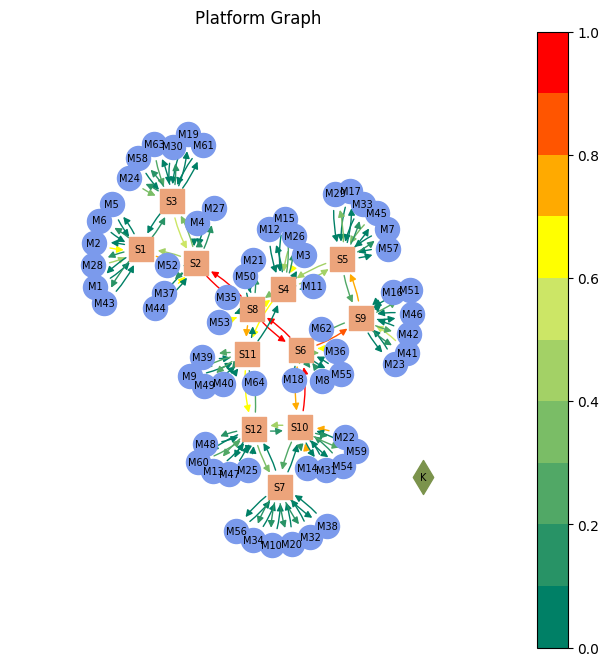

Best Solution: 0.54 found in 413.53s
{'max_load': 2.10222818, 'overload_count': 5, 'mean_hops': 4.058673469387755, 'max_hops': 7, 'latency_score': 0.0006519815897472679, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5393357860968241, 'num_modules': 64, 'num_switches': 12, 'num_links': 160, 'search_time': 413.527863740921}


Starting search epoch 1 with seed 700205256


 48%|█████████████████████████████████████████████▏                                                 | 38/80 [07:50<08:40, 12.39s/it, iterations=791, nodes=548]


Exploration terminated: node is terminal by condition
Explored total of 10388 configurations for a total of 3116400 solutions in 11118 iterations
Exploration took 470.63s
Monte Carlo tree  size: 548 nodes
{'max_load': 2.47011946, 'overload_count': 9, 'mean_hops': 4.622448979591836, 'max_hops': 9, 'latency_score': 6.619923186760155e-06, 'connectivity_score': 0.7936507936507936, 'SW_connectivity': 0.7936507936507936, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5008381031906615, 'num_modules': 64, 'num_switches': 12, 'num_links': 158}


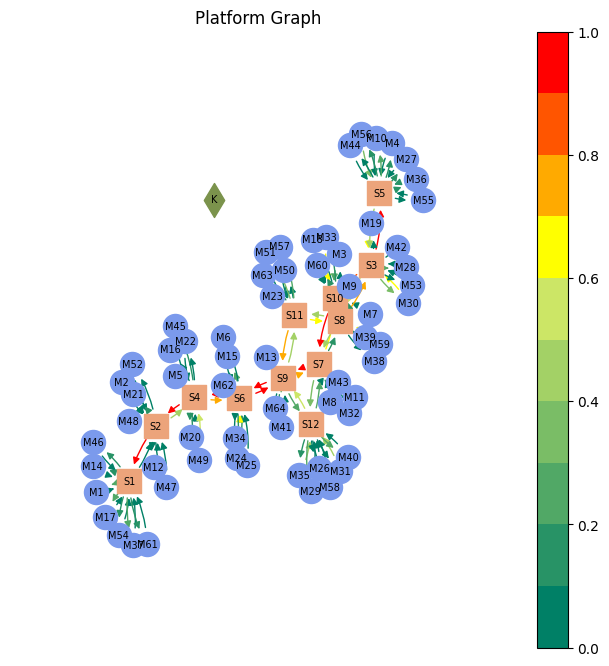

Best Solution: 0.50 found in 477.08s
{'max_load': 1.92272954, 'overload_count': 9, 'mean_hops': 4.686224489795919, 'max_hops': 10, 'latency_score': 1.2943821474390865e-05, 'connectivity_score': 0.7936507936507936, 'SW_connectivity': 0.7936507936507936, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5008406327499765, 'num_modules': 64, 'num_switches': 12, 'num_links': 158, 'search_time': 477.0803918838501}


Starting search epoch 2 with seed 991589811


 22%|█████████████████████▏                                                                        | 18/80 [03:48<13:07, 12.71s/it, iterations=1559, nodes=171]


Exploration terminated: node is terminal by condition
Explored total of 4098 configurations for a total of 1229400 solutions in 5640 iterations
Exploration took 228.75s
Monte Carlo tree  size: 171 nodes
{'connectivity_score': 0.8888888888888888, 'SW_connectivity': 0.8888888888888888, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5198830742690058, 'num_modules': 64, 'num_switches': 12, 'num_links': 102}


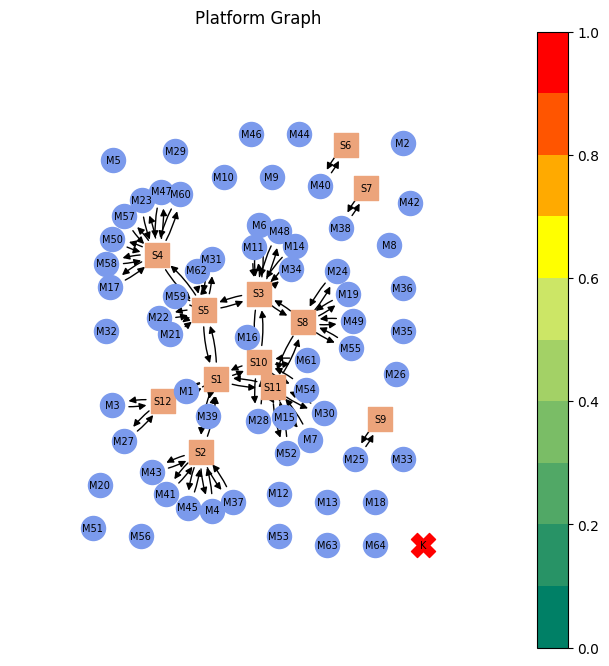

Best Solution: 0.52 found in 228.75s
{'connectivity_score': 0.8888888888888888, 'SW_connectivity': 0.8888888888888888, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5198830742690058, 'num_modules': 64, 'num_switches': 12, 'num_links': 102, 'search_time': 228.75113701820374}


Starting search epoch 3 with seed 1073042120


 46%|███████████████████████████████████████████▍                                                  | 37/80 [07:37<08:51, 12.36s/it, iterations=1274, nodes=606]


Exploration terminated: node is terminal by condition
Explored total of 9846 configurations for a total of 2953800 solutions in 11129 iterations
Exploration took 457.29s
Monte Carlo tree  size: 606 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.534632068365368, 'num_modules': 64, 'num_switches': 13, 'num_links': 158}


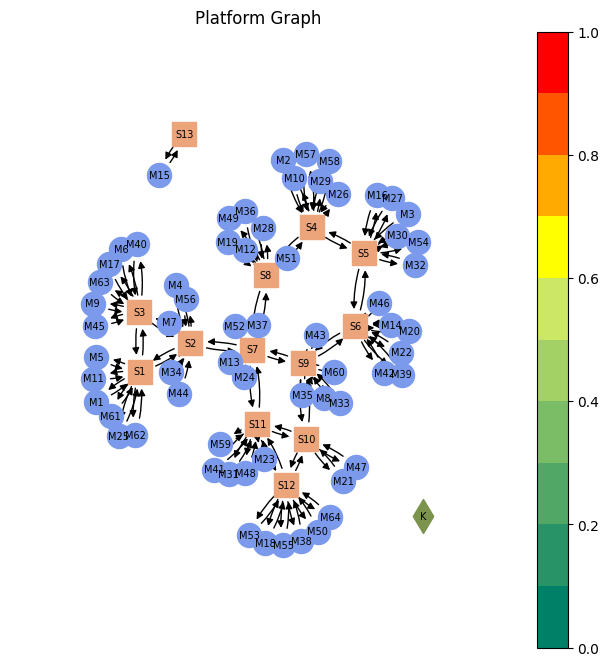

Best Solution: 0.53 found in 462.19s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.534632068365368, 'num_modules': 64, 'num_switches': 13, 'num_links': 158, 'search_time': 462.1901171207428}


Starting search epoch 4 with seed 1544843536


 29%|███████████████████████████                                                                   | 23/80 [04:49<11:56, 12.57s/it, iterations=1153, nodes=161]


Exploration terminated: node is terminal by condition
Explored total of 4836 configurations for a total of 1450800 solutions in 5894 iterations
Exploration took 289.03s
Monte Carlo tree  size: 161 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.0967741935483871, 'SW_connectivity': 0.0967741935483871, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.3614601356009055, 'num_modules': 64, 'num_switches': 12, 'num_links': 148}


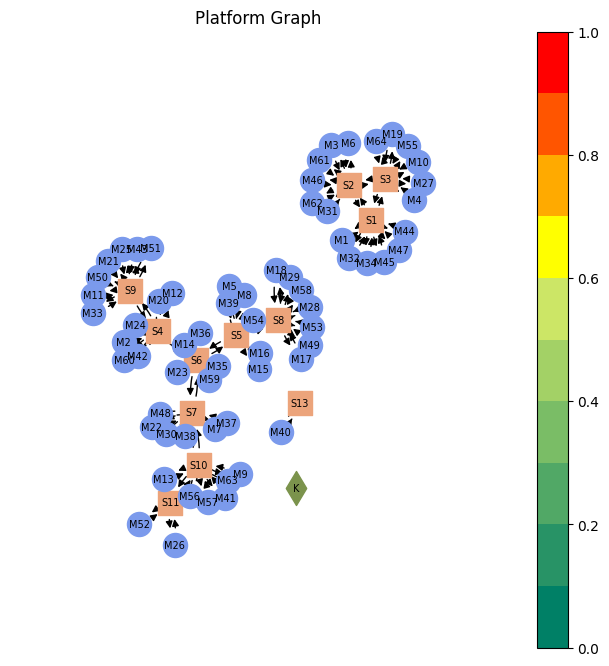

Best Solution: 0.36 found in 290.35s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.0967741935483871, 'SW_connectivity': 0.0967741935483871, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.3614601356009055, 'num_modules': 64, 'num_switches': 12, 'num_links': 148, 'search_time': 290.3514666557312}


Starting search epoch 5 with seed 494792457


 42%|███████████████████████████████████████▉                                                      | 34/80 [07:02<09:31, 12.42s/it, iterations=1236, nodes=467]


Exploration terminated: node is terminal by condition
Explored total of 9144 configurations for a total of 2743200 solutions in 10178 iterations
Exploration took 422.21s
Monte Carlo tree  size: 467 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.9545454545454546, 'SW_connectivity': 0.9545454545454546, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.5285714623047618, 'num_modules': 64, 'num_switches': 13, 'num_links': 160}


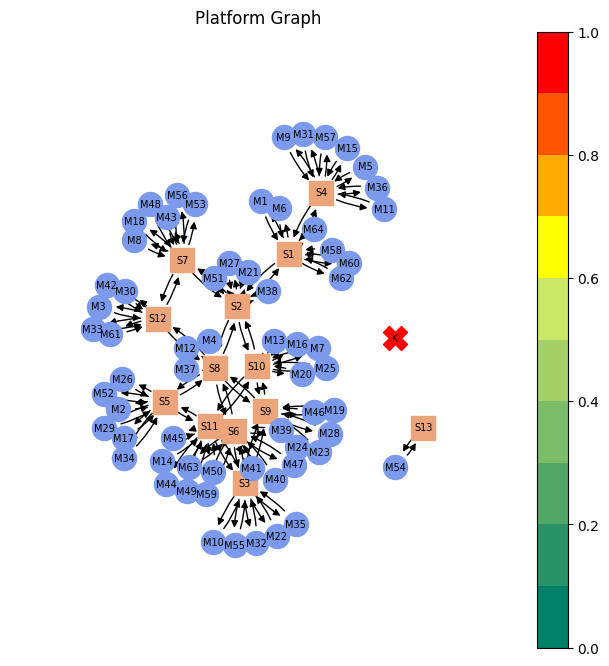

Best Solution: 0.53 found in 428.94s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.9545454545454546, 'SW_connectivity': 0.9545454545454546, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.5285714623047618, 'num_modules': 64, 'num_switches': 13, 'num_links': 160, 'search_time': 428.9372069835663}


Starting search epoch 6 with seed 697537645


 32%|██████████████████████████████▉                                                                | 26/80 [05:25<11:15, 12.50s/it, iterations=767, nodes=351]


Exploration terminated: node is terminal by condition
Explored total of 6238 configurations for a total of 1871400 solutions in 6981 iterations
Exploration took 325.02s
Monte Carlo tree  size: 351 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.9393939393939394, 'SW_connectivity': 0.9393939393939394, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.5255411592744588, 'num_modules': 64, 'num_switches': 13, 'num_links': 158}


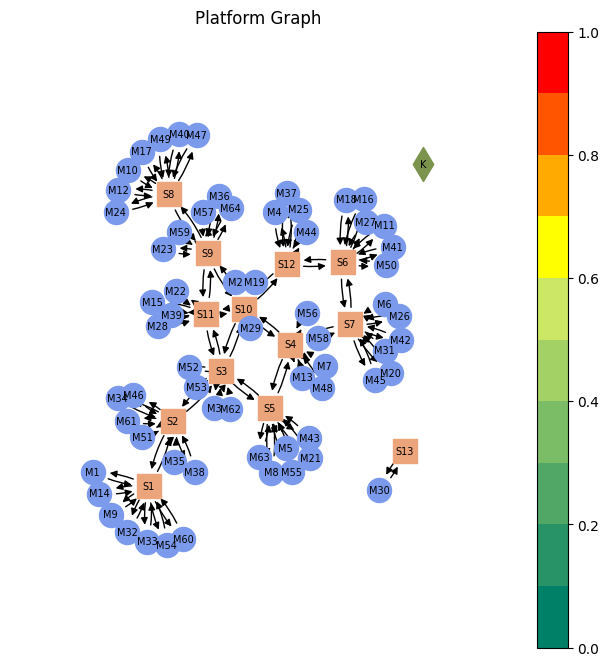

Best Solution: 0.53 found in 331.67s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.9393939393939394, 'SW_connectivity': 0.9393939393939394, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.5255411592744588, 'num_modules': 64, 'num_switches': 13, 'num_links': 158, 'search_time': 331.66885256767273}


Starting search epoch 7 with seed 452066989


 28%|█████████████████████████▊                                                                    | 22/80 [04:36<12:09, 12.58s/it, iterations=1037, nodes=428]


Exploration terminated: node is terminal by condition
Explored total of 5481 configurations for a total of 1644300 solutions in 6420 iterations
Exploration took 276.71s
Monte Carlo tree  size: 428 nodes
{'connectivity_score': 0.7555555555555555, 'SW_connectivity': 0.7555555555555555, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.49321640760233915, 'num_modules': 64, 'num_switches': 12, 'num_links': 104}


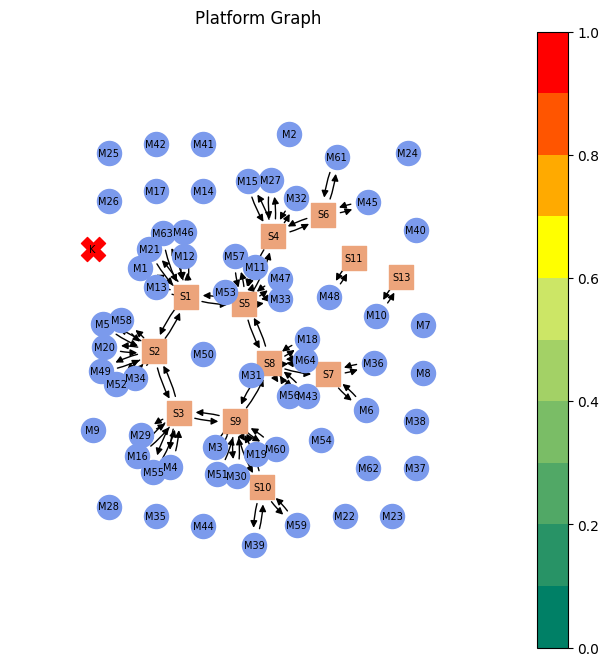

Best Solution: 0.49 found in 276.71s
{'connectivity_score': 0.7555555555555555, 'SW_connectivity': 0.7555555555555555, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.49321640760233915, 'num_modules': 64, 'num_switches': 12, 'num_links': 104, 'search_time': 276.70806550979614}


Starting search epoch 8 with seed 589159583


 35%|████████████████████████████████▉                                                             | 28/80 [05:49<10:48, 12.47s/it, iterations=1093, nodes=258]


Exploration terminated: node is terminal by condition
Explored total of 7280 configurations for a total of 2184000 solutions in 8199 iterations
Exploration took 349.08s
Monte Carlo tree  size: 258 nodes
{'max_load': 2.16808088, 'overload_count': 6, 'mean_hops': 4.280612244897959, 'max_hops': 7, 'latency_score': 0.00020944487772424066, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5391587714120148, 'num_modules': 64, 'num_switches': 12, 'num_links': 158}


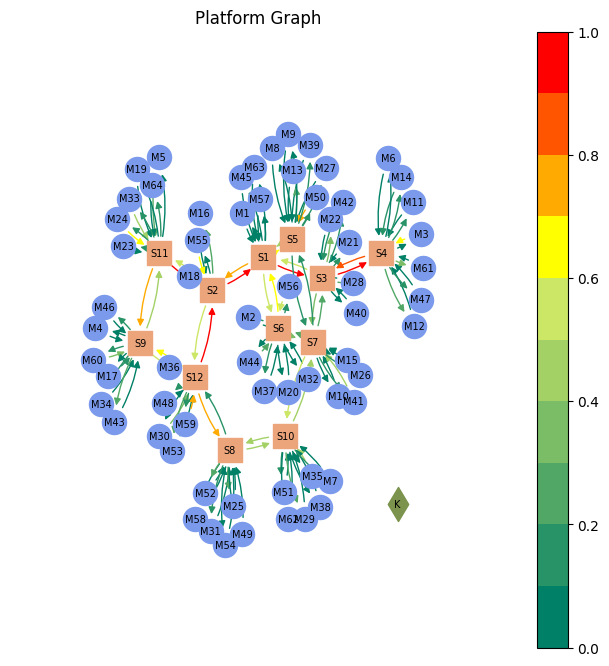

Best Solution: 0.54 found in 356.02s
{'max_load': 1.56838456, 'overload_count': 4, 'mean_hops': 4.025510204081633, 'max_hops': 7, 'latency_score': 0.003482568505733645, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'shortest_routing_options': 291504128, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5404680208632185, 'num_modules': 64, 'num_switches': 12, 'num_links': 158, 'search_time': 356.0182235240936}


Starting search epoch 9 with seed 517671805


 50%|███████████████████████████████████████████████▌                                               | 40/80 [08:13<08:13, 12.33s/it, iterations=780, nodes=603]


Exploration terminated: node is terminal by condition
Explored total of 11573 configurations for a total of 3471900 solutions in 12230 iterations
Exploration took 493.14s
Monte Carlo tree  size: 603 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.8666666666666667, 'SW_connectivity': 0.8666666666666667, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.5109957047290042, 'num_modules': 64, 'num_switches': 13, 'num_links': 160}


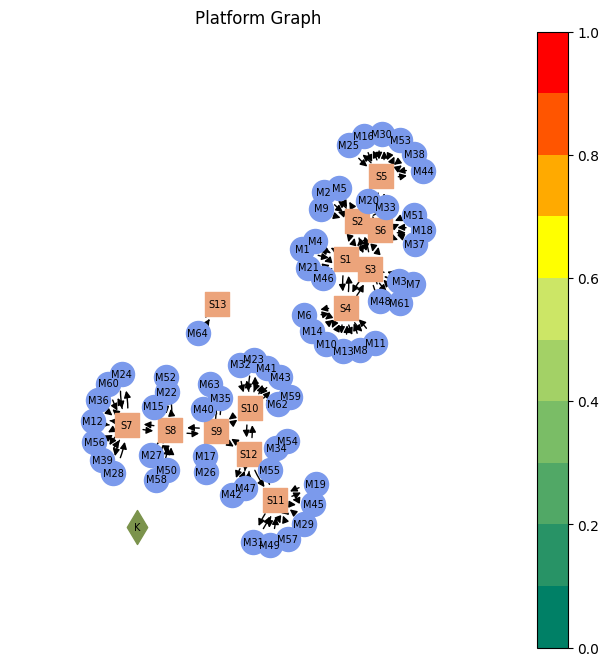

Best Solution: 0.51 found in 497.47s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.8666666666666667, 'SW_connectivity': 0.8666666666666667, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.5109957047290042, 'num_modules': 64, 'num_switches': 13, 'num_links': 160, 'search_time': 497.47357988357544}


Starting search epoch 10 with seed 536895217


 34%|███████████████████████████████▋                                                              | 27/80 [05:37<11:01, 12.49s/it, iterations=2046, nodes=473]


Exploration terminated: node is terminal by condition
Explored total of 7767 configurations for a total of 2330100 solutions in 10055 iterations
Exploration took 337.19s
Monte Carlo tree  size: 473 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.6410256410256411, 'SW_connectivity': 0.6410256410256411, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.4703104250963563, 'num_modules': 64, 'num_switches': 12, 'num_links': 154}


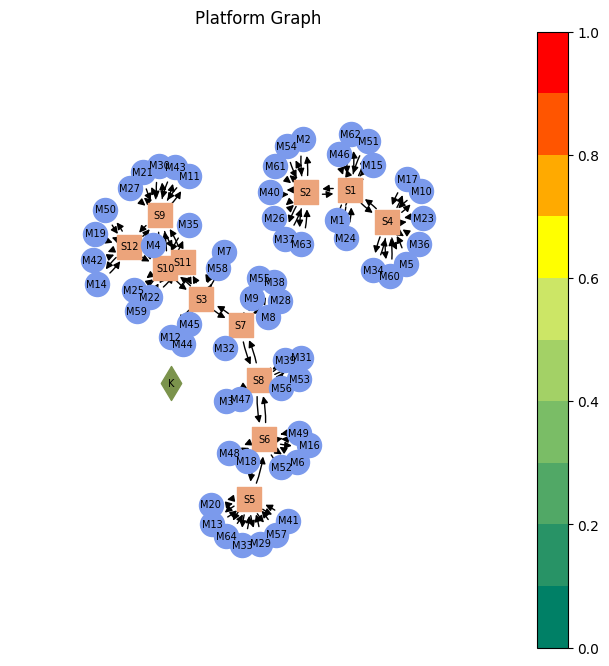

Best Solution: 0.47 found in 339.37s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.6410256410256411, 'SW_connectivity': 0.6410256410256411, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.4703104250963563, 'num_modules': 64, 'num_switches': 12, 'num_links': 154, 'search_time': 339.3669877052307}


Starting search epoch 11 with seed 1737530650


 38%|███████████████████████████████████▎                                                          | 30/80 [06:15<10:26, 12.53s/it, iterations=1541, nodes=316]


Exploration terminated: node is terminal by condition
Explored total of 7789 configurations for a total of 2336700 solutions in 10249 iterations
Exploration took 375.94s
Monte Carlo tree  size: 316 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.7575757575757576, 'SW_connectivity': 0.7575757575757576, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.4891775229108225, 'num_modules': 64, 'num_switches': 13, 'num_links': 156}


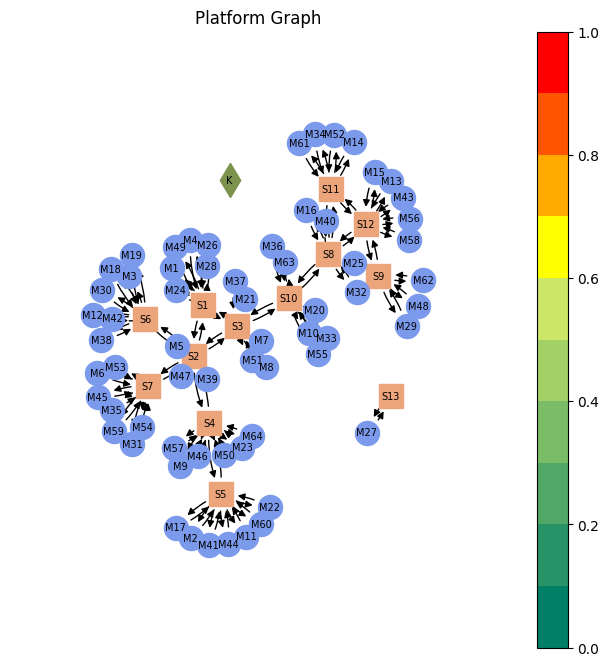

Best Solution: 0.49 found in 378.94s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.7575757575757576, 'SW_connectivity': 0.7575757575757576, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.4891775229108225, 'num_modules': 64, 'num_switches': 13, 'num_links': 156, 'search_time': 378.93620014190674}


Starting search epoch 12 with seed 2000095732


 28%|█████████████████████████▊                                                                    | 22/80 [04:38<12:14, 12.66s/it, iterations=1206, nodes=410]


Exploration terminated: node is terminal by condition
Explored total of 5704 configurations for a total of 1711200 solutions in 6767 iterations
Exploration took 278.57s
Monte Carlo tree  size: 410 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.4666666666666667, 'SW_connectivity': 0.4666666666666667, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.4309957047290043, 'num_modules': 64, 'num_switches': 13, 'num_links': 154}


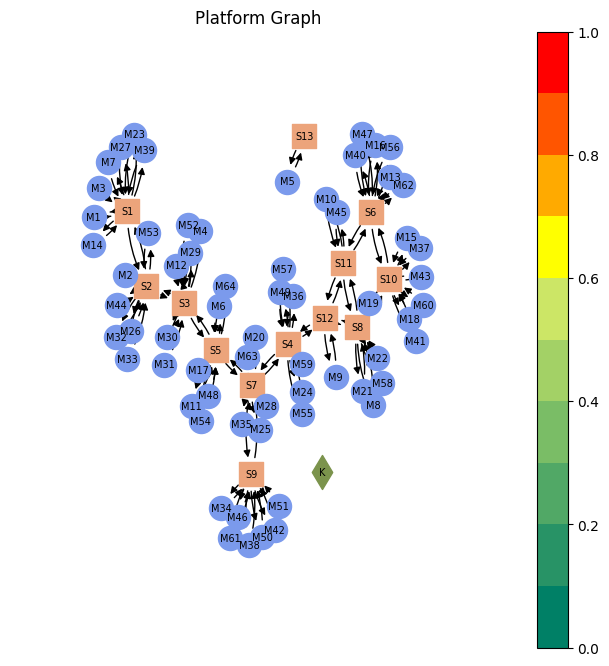

Best Solution: 0.43 found in 281.49s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.4666666666666667, 'SW_connectivity': 0.4666666666666667, 'total_cost': 770, 'cost_score': 0.8441558441558441, 'score': 0.4309957047290043, 'num_modules': 64, 'num_switches': 13, 'num_links': 154, 'search_time': 281.49315094947815}


Starting search epoch 13 with seed 771279219


 25%|███████████████████████▊                                                                       | 20/80 [04:12<12:38, 12.63s/it, iterations=853, nodes=194]


Exploration terminated: node is terminal by condition
Explored total of 5089 configurations for a total of 1526700 solutions in 5940 iterations
Exploration took 252.70s
Monte Carlo tree  size: 194 nodes
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.8113207547169812, 'SW_connectivity': 0.8113207547169812, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5043694478346243, 'num_modules': 64, 'num_switches': 12, 'num_links': 152}


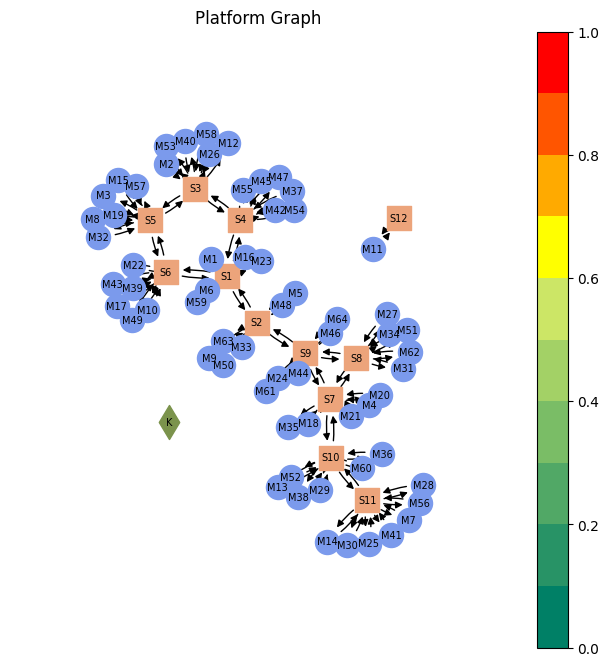

Best Solution: 0.50 found in 255.46s
{'max_load': 'N.A', 'overload_count': 'N.A', 'mean_hops': inf, 'max_hops': inf, 'latency_score': 1e-09, 'connectivity_score': 0.8113207547169812, 'SW_connectivity': 0.8113207547169812, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5043694478346243, 'num_modules': 64, 'num_switches': 12, 'num_links': 152, 'search_time': 255.4580979347229}


Starting search epoch 14 with seed 782820078


 42%|███████████████████████████████████████▉                                                      | 34/80 [07:01<09:29, 12.39s/it, iterations=1158, nodes=494]


Exploration terminated: node is terminal by condition
Explored total of 9253 configurations for a total of 2775900 solutions in 10218 iterations
Exploration took 421.14s
Monte Carlo tree  size: 494 nodes
{'connectivity_score': 0.9642857142857143, 'SW_connectivity': 0.9642857142857143, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.534962439348371, 'num_modules': 64, 'num_switches': 12, 'num_links': 84}


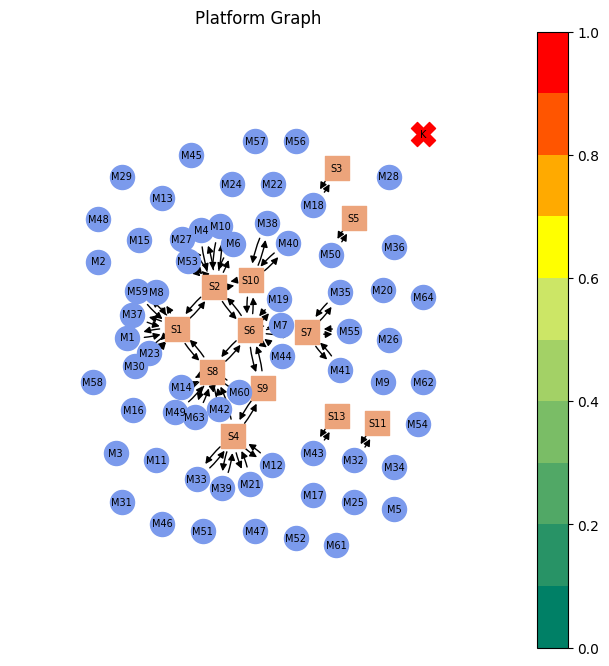

Best Solution: 0.53 found in 421.14s
{'connectivity_score': 0.9642857142857143, 'SW_connectivity': 0.9642857142857143, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.534962439348371, 'num_modules': 64, 'num_switches': 12, 'num_links': 84, 'search_time': 421.1359603404999}


Starting search epoch 15 with seed 1105322747


 36%|██████████████████████████████████                                                            | 29/80 [06:00<10:34, 12.44s/it, iterations=1480, nodes=401]


Exploration terminated: node is terminal by condition
Explored total of 7602 configurations for a total of 2280600 solutions in 8955 iterations
Exploration took 360.87s
Monte Carlo tree  size: 401 nodes
{'max_load': 2.56103047, 'overload_count': 10, 'mean_hops': 4.762755102040816, 'max_hops': 9, 'latency_score': 2.1096949155200615e-06, 'connectivity_score': 0.45161290322580644, 'SW_connectivity': 0.45161290322580644, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.43242872101435553, 'num_modules': 64, 'num_switches': 12, 'num_links': 154}


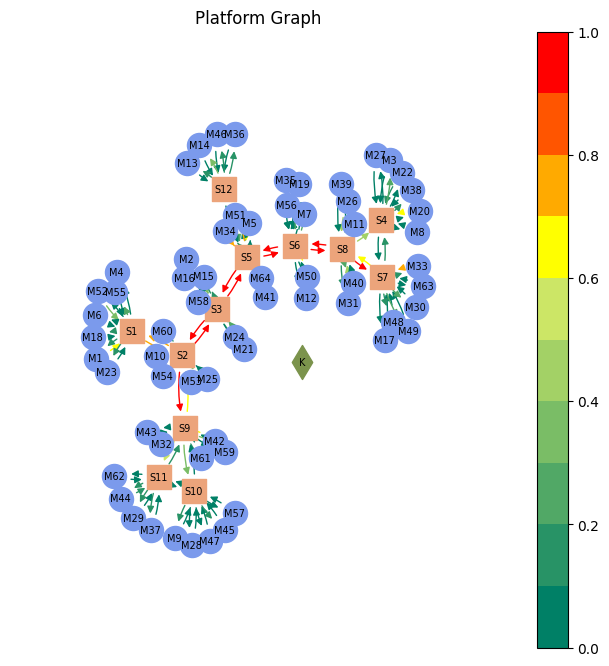

Best Solution: 0.43 found in 366.40s
{'max_load': 2.88306528, 'overload_count': 10, 'mean_hops': 4.89030612244898, 'max_hops': 9, 'latency_score': 1.3737871034118471e-06, 'connectivity_score': 0.45161290322580644, 'SW_connectivity': 0.45161290322580644, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.4324284266512307, 'num_modules': 64, 'num_switches': 12, 'num_links': 154, 'search_time': 366.3981716632843}


Starting search epoch 16 with seed 394953105


 28%|█████████████████████████▊                                                                    | 22/80 [04:36<12:10, 12.59s/it, iterations=1287, nodes=208]


Exploration terminated: node is terminal by condition
Explored total of 5792 configurations for a total of 1737600 solutions in 7072 iterations
Exploration took 276.99s
Monte Carlo tree  size: 208 nodes
{'max_load': 2.52070455, 'overload_count': 10, 'mean_hops': 5.051020408163265, 'max_hops': 10, 'latency_score': 2.0921385386764347e-06, 'connectivity_score': 0.7288135593220338, 'SW_connectivity': 0.7288135593220338, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.4878688452110503, 'num_modules': 64, 'num_switches': 12, 'num_links': 160}


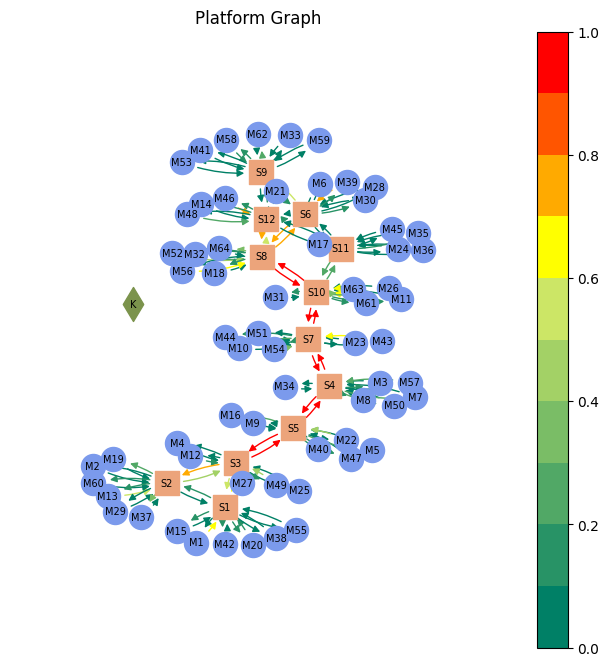

Best Solution: 0.49 found in 283.98s
{'max_load': 2.63158036, 'overload_count': 9, 'mean_hops': 4.88265306122449, 'max_hops': 10, 'latency_score': 5.121736574545861e-06, 'connectivity_score': 0.7288135593220338, 'SW_connectivity': 0.7288135593220338, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.48787005705026465, 'num_modules': 64, 'num_switches': 12, 'num_links': 160, 'search_time': 283.9795935153961}


Starting search epoch 17 with seed 793811089


 38%|███████████████████████████████████▋                                                           | 30/80 [06:13<10:21, 12.43s/it, iterations=880, nodes=430]


Exploration terminated: node is terminal by condition
Explored total of 8157 configurations for a total of 2447100 solutions in 8817 iterations
Exploration took 373.04s
Monte Carlo tree  size: 430 nodes
{'max_load': 1.90541728, 'overload_count': 8, 'mean_hops': 4.385204081632653, 'max_hops': 8, 'latency_score': 3.842275925295605e-05, 'connectivity_score': 0.8939393939393939, 'SW_connectivity': 0.8939393939393939, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.520908544382808, 'num_modules': 64, 'num_switches': 12, 'num_links': 158}


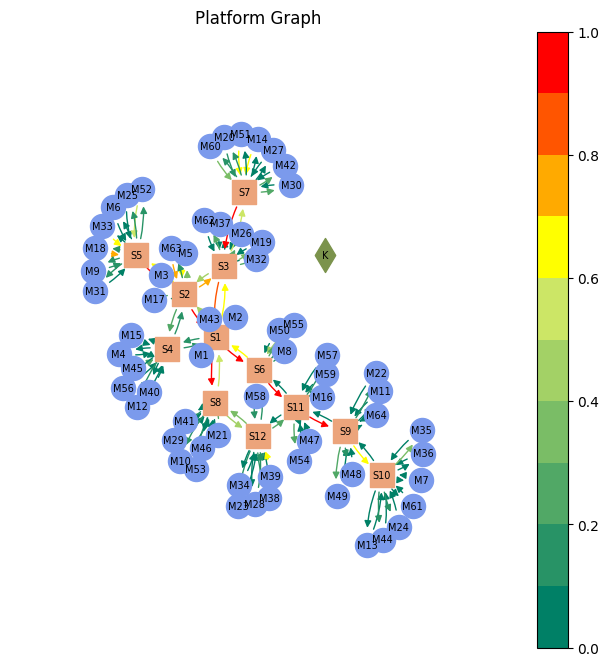

Best Solution: 0.52 found in 377.60s
{'max_load': 1.31467032, 'overload_count': 9, 'mean_hops': 4.364795918367347, 'max_hops': 8, 'latency_score': 2.9717865721534963e-05, 'connectivity_score': 0.8939393939393939, 'SW_connectivity': 0.8939393939393939, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5209050624253954, 'num_modules': 64, 'num_switches': 12, 'num_links': 158, 'search_time': 377.6039078235626}


Starting search epoch 18 with seed 376231170


 22%|█████████████████████▏                                                                        | 18/80 [03:48<13:07, 12.70s/it, iterations=1570, nodes=252]


Exploration terminated: node is terminal by condition
Explored total of 4528 configurations for a total of 1358400 solutions in 5997 iterations
Exploration took 228.64s
Monte Carlo tree  size: 252 nodes
{'connectivity_score': 0.0, 'SW_connectivity': 0.0, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.34210529649122806, 'num_modules': 64, 'num_switches': 12, 'num_links': 74}


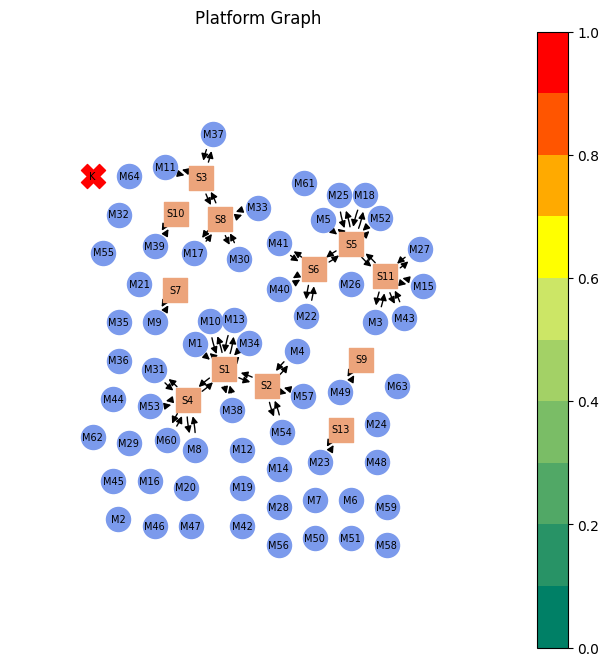

Best Solution: 0.34 found in 228.64s
{'connectivity_score': 0.0, 'SW_connectivity': 0.0, 'latency_score': 0, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.34210529649122806, 'num_modules': 64, 'num_switches': 12, 'num_links': 74, 'search_time': 228.6387424468994}


Starting search epoch 19 with seed 689656761


 35%|█████████████████████████████████▎                                                             | 28/80 [05:48<10:47, 12.46s/it, iterations=915, nodes=494]


Exploration terminated: node is terminal by condition
Explored total of 7538 configurations for a total of 2261400 solutions in 8236 iterations
Exploration took 348.88s
Monte Carlo tree  size: 494 nodes
{'max_load': 2.94231104, 'overload_count': 7, 'mean_hops': 4.448979591836735, 'max_hops': 8, 'latency_score': 2.816539717022706e-05, 'connectivity_score': 0.7424242424242424, 'SW_connectivity': 0.7424242424242424, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.49060141113494465, 'num_modules': 64, 'num_switches': 12, 'num_links': 156}


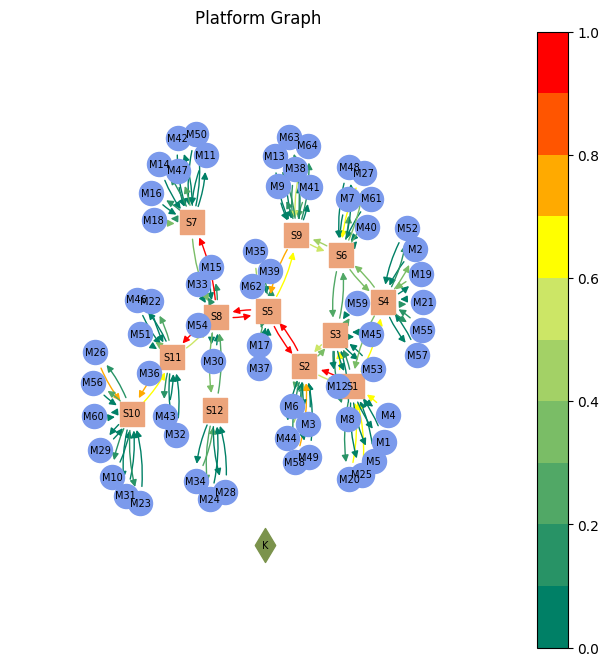

Best Solution: 0.49 found in 353.54s
{'max_load': 1.94457374, 'overload_count': 8, 'mean_hops': 4.346938775510204, 'max_hops': 8, 'latency_score': 3.6909489864994335e-05, 'connectivity_score': 0.7424242424242424, 'SW_connectivity': 0.7424242424242424, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.4906049087720225, 'num_modules': 64, 'num_switches': 12, 'num_links': 156, 'search_time': 353.5430521965027}


Starting search epoch 20 with seed 741051424


 51%|████████████████████████████████████████████████▏                                             | 41/80 [08:25<08:00, 12.32s/it, iterations=1150, nodes=750]


Exploration terminated: node is terminal by condition
Explored total of 11744 configurations for a total of 3523200 solutions in 12776 iterations
Exploration took 505.08s
Monte Carlo tree  size: 750 nodes
{'max_load': 1.37341637, 'overload_count': 6, 'mean_hops': 3.961734693877551, 'max_hops': 7, 'latency_score': 0.000611066195337487, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5393194199390601, 'num_modules': 64, 'num_switches': 12, 'num_links': 160}


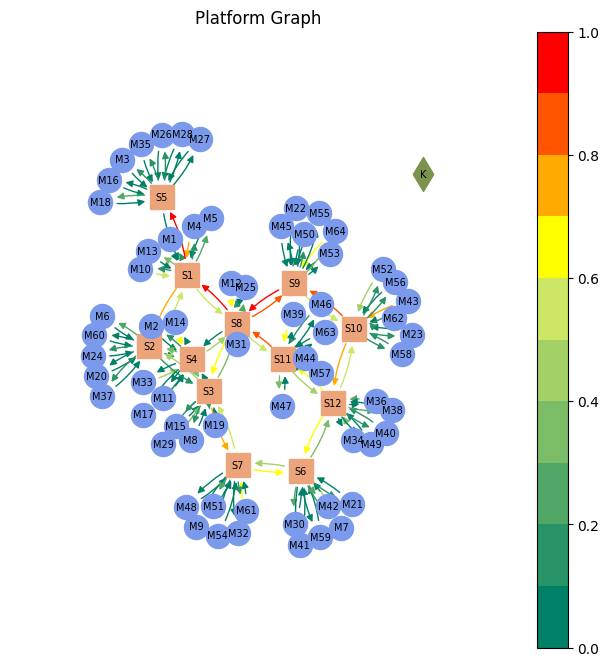

Best Solution: 0.54 found in 512.04s
{'max_load': 1.00325848, 'overload_count': 4, 'mean_hops': 4.086734693877551, 'max_hops': 7, 'latency_score': 0.006952373219277305, 'connectivity_score': 0.9848484848484849, 'SW_connectivity': 0.9848484848484849, 'shortest_routing_options': 893911040, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.541855942748636, 'num_modules': 64, 'num_switches': 12, 'num_links': 160, 'search_time': 512.0428869724274}


Starting search epoch 21 with seed 1805061792


 40%|██████████████████████████████████████                                                         | 32/80 [06:36<09:55, 12.41s/it, iterations=451, nodes=471]


Exploration terminated: node is terminal by condition
Explored total of 8964 configurations for a total of 2689200 solutions in 9248 iterations
Exploration took 396.99s
Monte Carlo tree  size: 471 nodes
{'max_load': 1.63173907, 'overload_count': 11, 'mean_hops': 4.678571428571429, 'max_hops': 9, 'latency_score': 2.524368892628512e-06, 'connectivity_score': 0.8923076923076924, 'SW_connectivity': 0.8923076923076924, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5205678447003236, 'num_modules': 64, 'num_switches': 12, 'num_links': 158}


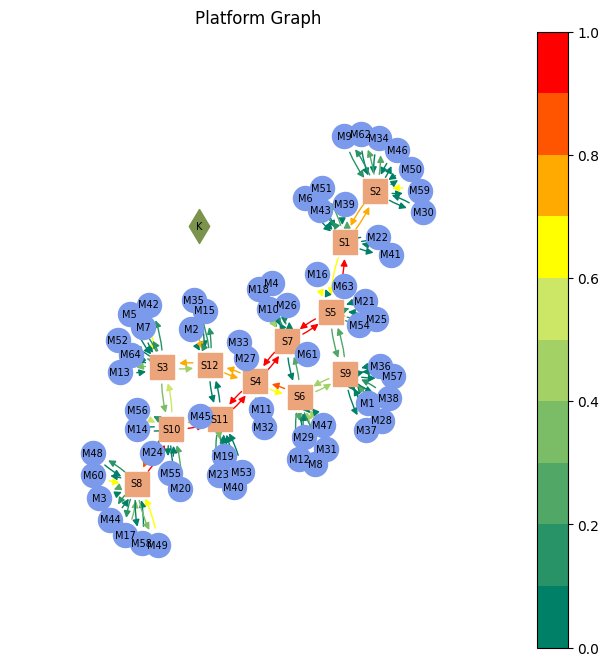

Best Solution: 0.52 found in 402.04s
{'max_load': 2.54102596, 'overload_count': 9, 'mean_hops': 4.627551020408164, 'max_hops': 9, 'latency_score': 6.0517500676906855e-06, 'connectivity_score': 0.8923076923076924, 'SW_connectivity': 0.8923076923076924, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5205692556527937, 'num_modules': 64, 'num_switches': 12, 'num_links': 158, 'search_time': 402.042560338974}


Starting search epoch 22 with seed 180671109


 41%|███████████████████████████████████████▏                                                       | 33/80 [06:50<09:45, 12.45s/it, iterations=854, nodes=675]


Exploration terminated: node is terminal by condition
Explored total of 9204 configurations for a total of 2761200 solutions in 9827 iterations
Exploration took 411.00s
Monte Carlo tree  size: 675 nodes
{'max_load': 1.508756, 'overload_count': 7, 'mean_hops': 4.125, 'max_hops': 6, 'latency_score': 0.00018229873065487578, 'connectivity_score': 0.7878787878787878, 'SW_connectivity': 0.7878787878787878, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.49975397355924756, 'num_modules': 64, 'num_switches': 12, 'num_links': 154}


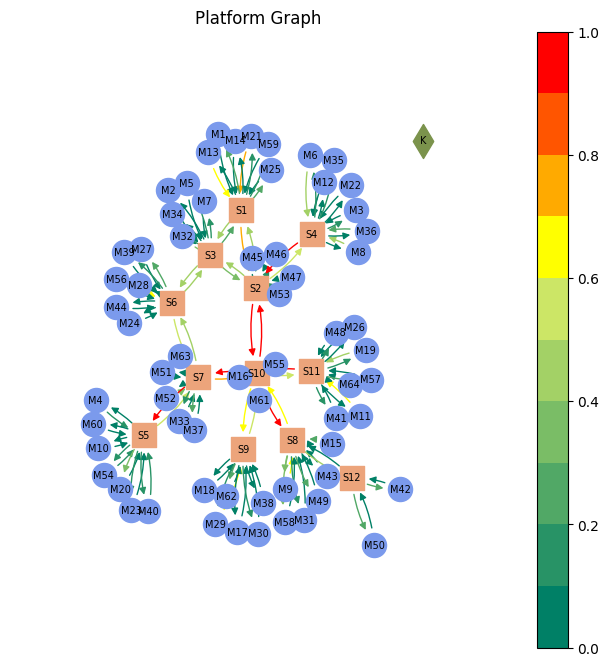

Best Solution: 0.50 found in 415.40s
{'max_load': 2.20236848, 'overload_count': 6, 'mean_hops': 4.10969387755102, 'max_hops': 6, 'latency_score': 0.00020900299773744184, 'connectivity_score': 0.7878787878787878, 'SW_connectivity': 0.7878787878787878, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.49976465526608055, 'num_modules': 64, 'num_switches': 12, 'num_links': 154, 'search_time': 415.4023268222809}


Starting search epoch 23 with seed 476174338


 39%|████████████████████████████████████▊                                                          | 31/80 [06:24<10:08, 12.42s/it, iterations=895, nodes=394]


Exploration terminated: node is terminal by condition
Explored total of 8265 configurations for a total of 2479500 solutions in 8955 iterations
Exploration took 384.93s
Monte Carlo tree  size: 394 nodes
{'max_load': 2.58965362, 'overload_count': 10, 'mean_hops': 4.627551020408164, 'max_hops': 8, 'latency_score': 2.0950196286184013e-06, 'connectivity_score': 0.6818181818181818, 'SW_connectivity': 0.6818181818181818, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.4784697708627158, 'num_modules': 64, 'num_switches': 12, 'num_links': 158}


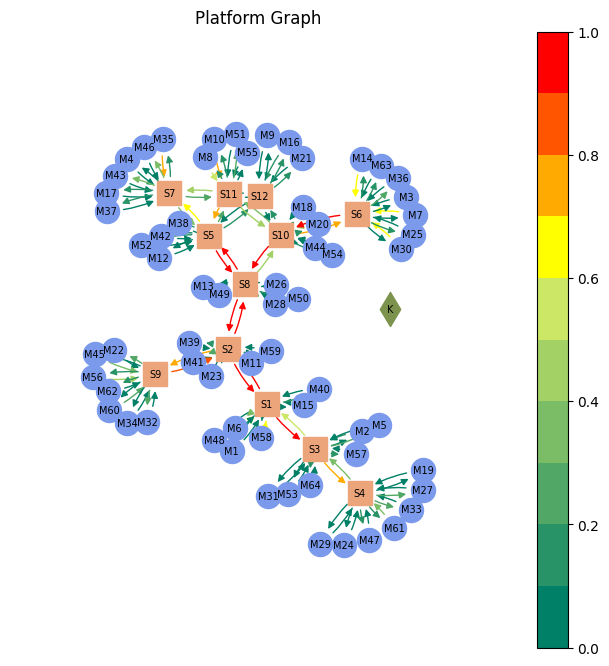

Best Solution: 0.48 found in 390.07s
{'max_load': 2.15097304, 'overload_count': 9, 'mean_hops': 4.571428571428571, 'max_hops': 8, 'latency_score': 9.975336382325159e-06, 'connectivity_score': 0.6818181818181818, 'SW_connectivity': 0.6818181818181818, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.47847292298941735, 'num_modules': 64, 'num_switches': 12, 'num_links': 158, 'search_time': 390.06542015075684}


Starting search epoch 24 with seed 33084953


 48%|████████████████████████████████████████████▋                                                 | 38/80 [07:49<08:38, 12.35s/it, iterations=1381, nodes=585]


Exploration terminated: node is terminal by condition
Explored total of 10930 configurations for a total of 3279000 solutions in 12466 iterations
Exploration took 469.28s
Monte Carlo tree  size: 585 nodes
{'max_load': 2.50314914, 'overload_count': 8, 'mean_hops': 4.584183673469388, 'max_hops': 9, 'latency_score': 1.7411123202544456e-05, 'connectivity_score': 0.859375, 'SW_connectivity': 0.859375, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.5139872609405091, 'num_modules': 64, 'num_switches': 12, 'num_links': 160}


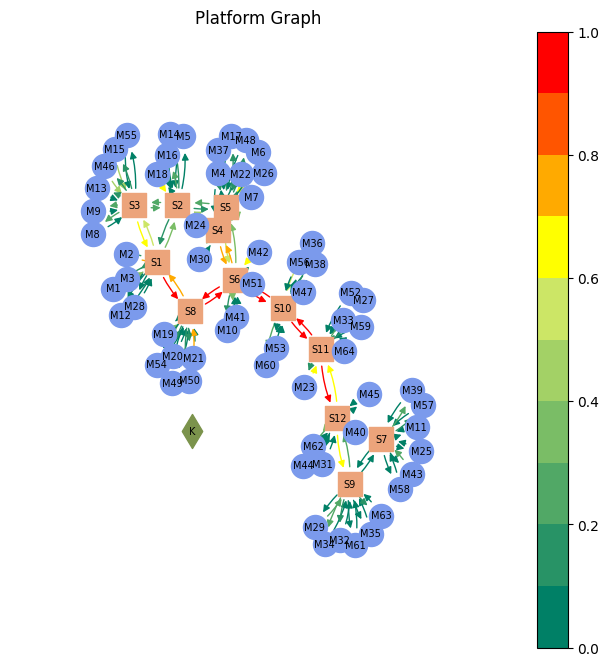

Best Solution: 0.51 found in 474.95s
{'max_load': 2.63284364, 'overload_count': 7, 'mean_hops': 4.612244897959184, 'max_hops': 9, 'latency_score': 4.0000361329931385e-05, 'connectivity_score': 0.859375, 'SW_connectivity': 0.859375, 'total_cost': 760, 'cost_score': 0.8552631578947368, 'score': 0.51399629663576, 'num_modules': 64, 'num_switches': 12, 'num_links': 160, 'search_time': 474.9542510509491}
0.0


In [13]:
save_file="configuration_ext"
grammar_file = "C:/Users/smora/Documents/LiU/Workspace//NetGAP/grammars/grammar3_8p.txt"

iterations = 25

total_generated=netgap_search(grammar_filename=grammar_file, print_graph=True, save_filename=save_file, save_attribute="latency_score",save_th=0.15,search_loops=iterations)
print(total_generated/iterations)